In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import pandas as pd
from scipy.stats import truncnorm

In [2]:
np.random.seed(0)
def get_surgery_time(mean,std):
    #sh,sc = (mean/std)**2,std**2/mean
    #return np.random.gamma(shape=sh,scale=sc)
    return truncnorm.rvs(-1,1,loc=mean,scale=std)

In [3]:
#problem parameters
specs = ['CARD','GASTRO','GYN','MED','ORTHO','URO']

surgery_data = {'CARD':[99.0,53.0],'GASTRO':[132.0,76.0],'GYN':[78.0,52.0],'MED':[75.0,32.0],'ORTHO':[142.0,58.0],'URO':[72.0,38.0]}

blocks = {'CARD':[2,6,16,28,32,33],'GASTRO':[1,8,14,15,22,27,34],'GYN':[4,11,12,18,19,24,25,30,35],'MED':[17,36],'ORTHO':[3,9,10,21,23,29,37],'URO':[5,7,13,20,26,31,38]}
block_len = [8*60.0 for i in range(32)]+[100*60.0 for i in range(len(specs))]
n_blocks = len(block_len)

n_surgeries = 125
percent_surg = {'CARD':14,'GASTRO':18,'GYN':28,'MED':5,'ORTHO':17,'URO':18}
surgeries = {}
tot = 0
for i in specs[:len(specs)-1]:
    surgeries[i] = round(n_surgeries*percent_surg[i]/100.0)
    tot += surgeries[i]
surgeries[specs[-1]] = n_surgeries-tot

surgery_nums = {}
t = 0
for s in specs:
    surgery_nums[s] = [t,t+surgeries[s]-1]
    t = t+surgeries[s]
    
print(surgeries)
print(surgery_nums)

{'CARD': 18, 'GASTRO': 22, 'GYN': 35, 'MED': 6, 'ORTHO': 21, 'URO': 23}
{'CARD': [0, 17], 'GASTRO': [18, 39], 'GYN': [40, 74], 'MED': [75, 80], 'ORTHO': [81, 101], 'URO': [102, 124]}


In [4]:
np.random.seed(0)
cib = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)]) # block costs
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]+1):
        #costs = sorted([np.random.randint(low=1,high=5)*100 for _ in range(len(blocks[s])-1)])
        costs = [np.random.randint(low=1,high=5)*100 for _ in range(len(blocks[s])-1)]
        f = 0
        for b in blocks[s][:len(blocks[s])-1]:
            cib[i,b-1] = costs[f]
            f += 1
            
        
dummy_cost = 1000
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]+1):
        b = blocks[s][-1]
        cib[i,b-1] = dummy_cost

cob = np.array([5.0 for _ in range(n_blocks)])
cgb = np.array([5.0/1.5 for _ in range(n_blocks-len(specs))]+[0.0 for _ in range(len(specs))])

In [5]:
cib[surgery_nums['URO'][0]:surgery_nums['URO'][1]+1,[i-1 for i in blocks['URO']]]

array([[ 300.,  400.,  300.,  200.,  100.,  100., 1000.],
       [ 200.,  100.,  100.,  300.,  100.,  100., 1000.],
       [ 200.,  400.,  200.,  200.,  200.,  200., 1000.],
       [ 400.,  200.,  300.,  100.,  300.,  100., 1000.],
       [ 400.,  400.,  200.,  400.,  100.,  400., 1000.],
       [ 300.,  100.,  400.,  400.,  400.,  100., 1000.],
       [ 200.,  400.,  400.,  300.,  200.,  400., 1000.],
       [ 400.,  200.,  200.,  100.,  100.,  400., 1000.],
       [ 300.,  100.,  100.,  400.,  300.,  200., 1000.],
       [ 300.,  400.,  300.,  400.,  400.,  100., 1000.],
       [ 400.,  300.,  300.,  100.,  400.,  300., 1000.],
       [ 200.,  100.,  400.,  200.,  300.,  200., 1000.],
       [ 200.,  100.,  200.,  200.,  400.,  200., 1000.],
       [ 400.,  300.,  100.,  200.,  200.,  400., 1000.],
       [ 400.,  100.,  200.,  300.,  100.,  200., 1000.],
       [ 300.,  200.,  300.,  200.,  400.,  300., 1000.],
       [ 400.,  200.,  300.,  400.,  300.,  300., 1000.],
       [ 300.,

In [39]:
cib[108,[i-1 for i in blocks['URO']]]

array([ 200.,  400.,  400.,  300.,  200.,  400., 1000.])

In [7]:
#block and surgery of a speciality fesibility
p = [[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)]
p = np.array(p)
t = 0
for s in specs:
    for i in range(surgeries[s]):
        for b in blocks[s]:
            p[t,b-1] = 1.0
        t += 1

In [8]:
print(p[9,:])

[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


In [9]:
n_scenarios = 1000
avg_model = ConcreteModel()
avg_model.y = Var(RangeSet(n_surgeries),RangeSet(n_blocks),domain=Binary)
avg_model.o = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals,bounds=(0,120))
avg_model.g = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)

avg_model.atmost1 = ConstraintList()
for i in range(n_surgeries):
    avg_model.atmost1.add(expr=sum(avg_model.y[i+1,b] for b in range(1,n_blocks+1))==1)

avg_model.specfeas = ConstraintList()
for i in range(n_surgeries):
    for b in range(n_blocks):
        avg_model.specfeas.add(expr=avg_model.y[i+1,b+1] <= p[i,b])

avg_model.ogcons = ConstraintList()
for n in range(n_scenarios):
    t = 0
    for s in specs:
        for b in blocks[s]:
            avg_model.ogcons.add(expr=avg_model.o[b,n+1]-avg_model.g[b,n+1] == sum(get_surgery_time(surgery_data[s][0],surgery_data[s][1])*avg_model.y[i+1,b] for i in range(surgery_nums[s][0],surgery_nums[s][1]+1))-block_len[b-1])
''''
avg_model.atleast1inblock = ConstraintList()
for b in range(n_blocks-len(specs)):
    avg_model.atleast1inblock.add(expr=sum(avg_model.y[i+1,b+1] for i in range(n_surgeries))>=1.0)
'''
avg_model.cost = Objective(expr=sum(sum(avg_model.y[i+1,b+1]*cib[i,b] for i in range(n_surgeries)) for b in range(n_blocks))+(sum(cob[b]*avg_model.o[b+1,n+1]+cgb[b]*avg_model.g[b+1,n+1] for b in range(n_blocks) for n in range(n_scenarios)))/n_scenarios,sense=minimize)

In [10]:
opt = SolverFactory('cplex')
opt.options['timelimit'] = 1800
result = opt.solve(avg_model,tee=True)
print("Solver status :",result.solver.status)
print("Solver Termination condition :", result.solver.termination_condition)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\91824\AppData\Local\Temp\tmp3ofhspew.cplex.log' open.
CPLEX> New value for time limit in seconds: 1800
CPLEX> Problem 'C:\Users\91824\AppData\Local\Temp\tmpex1i0zcy.pyomo.lp' read.
Read time = 0.38 sec. (17.30 ticks)
CPLEX> Problem name         : C:\Users\91824\AppData\Local\Temp\tmpex1i0zcy.pyomo.lp
Objective sense      : Minimize
Variables            :   80751  [Nneg: 38001,  Box: 38000,  Binary: 4750]
Objective nonzeros   :   70897
Linear constraints   :   42876  [Less: 4750,  Equal: 38126]
  Nonzeros           :  982501
  RHS nonzeros       :   39023

Variables            : Min LB

    818   736    34777.6714   107    35105.6336    29240.8224   626481   16.71%
    830   739    34983.5636   109    35105.6336    29240.8224   629386   16.71%
    846   763    33433.9928   138    35105.6336    29240.8224   641823   16.71%
    858   771    33793.8485   115    35105.6336    29240.8224   644761   16.71%
    868   782    34587.2408    93    35105.6336    29240.8224   652653   16.71%
Elapsed time = 333.75 sec. (110271.10 ticks, tree = 161.04 MB, solutions = 8)
*   877+  682                        34990.7639    29240.8224            16.43%
    879   786        cutoff          34990.7639    29240.8224   655621   16.43%
*   880+  664                        34815.7111    29240.8224            16.01%
    880   778    34011.0441   111    34815.7111    29240.8224   649183   16.01%
    884   801    34243.4282    97    34815.7111    29240.8224   662797   16.01%
    890   807    34452.9029    90    34815.7111    29240.8224   665900   16.01%
    900   817    35058.9099    75    34815

   2609   796    29520.2309   242    34692.8088    29364.9268  2027820   15.36%
   2642   767    32598.9974   165    34692.8088    29364.9268  2012311   15.36%
   2721   824    31441.7089   197    34692.8088    29364.9268  2049448   15.36%
   2814   942    33886.9380   134    34692.8088    29364.9268  2133422   15.36%
   2920  1060    32281.8740   160    34692.8088    29364.9268  2203109   15.36%
   2965  1071    32536.2601   149    34692.8088    29364.9268  2211484   15.36%
   3009  1096    32366.6962   179    34692.8088    29364.9268  2231281   15.36%
   3066  1223    32583.4246   169    34692.8088    29364.9268  2319920   15.36%
   3137  1297    34430.7221   116    34692.8088    29364.9268  2378062   15.36%
Elapsed time = 1425.64 sec. (402073.41 ticks, tree = 270.41 MB, solutions = 18)
   3211  1319    30509.8157   224    34692.8088    29364.9268  2402693   15.36%
   3285  1391    34592.5258   129    34692.8088    29364.9268  2460018   15.36%
   3333  1430    33059.3399   175    346

In [11]:
#pd.DataFrame(cib).to_csv("cost_data_random_seed0.csv")

In [12]:
l = [[] for _ in range(n_blocks)]
for b in range(n_blocks):
    for i in range(n_surgeries):
        if avg_model.y[i+1,b+1].value > 0.0:
            l[b].append(i)

for i in range(len(l)):
    print("Block :",i+1, 'Surgeries',l[i])

Block : 1 Surgeries [20, 22, 28]
Block : 2 Surgeries [0, 9, 10, 13]
Block : 3 Surgeries [82, 90, 95]
Block : 4 Surgeries [49, 53, 71, 73]
Block : 5 Surgeries [108]
Block : 6 Surgeries [3, 6, 12, 17]
Block : 7 Surgeries [113, 114, 118, 119, 124]
Block : 8 Surgeries [26, 27, 31]
Block : 9 Surgeries [85, 94, 100]
Block : 10 Surgeries [83, 91, 96]
Block : 11 Surgeries [42, 43, 45, 50]
Block : 12 Surgeries [51, 52, 55, 70, 72]
Block : 13 Surgeries [103, 110, 115, 121]
Block : 14 Surgeries [25, 34, 36]
Block : 15 Surgeries [29, 32, 35]
Block : 16 Surgeries [2, 8, 15, 16]
Block : 17 Surgeries [75, 76, 77, 78, 79, 80]
Block : 18 Surgeries [41, 61, 64, 67]
Block : 19 Surgeries [40, 44, 57, 60, 74]
Block : 20 Surgeries [104, 109, 112, 117, 123]
Block : 21 Surgeries [81, 88, 93]
Block : 22 Surgeries [21, 24, 37]
Block : 23 Surgeries [84, 87, 92]
Block : 24 Surgeries [47, 58, 62, 65, 66]
Block : 25 Surgeries [48, 56, 63, 68]
Block : 26 Surgeries [106, 116, 120, 122]
Block : 27 Surgeries [18, 33, 3

<Figure size 720x432 with 0 Axes>

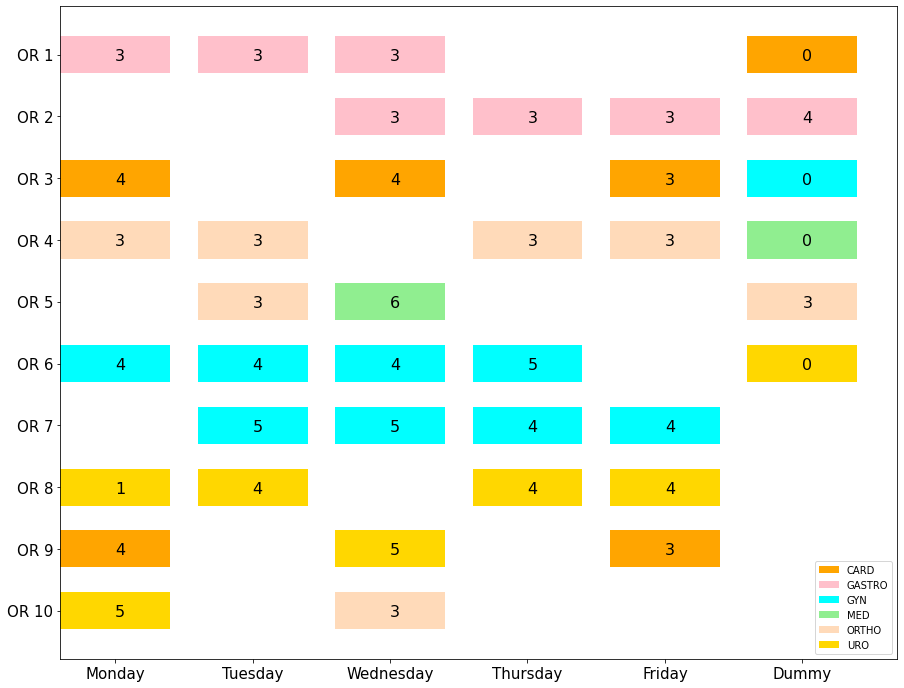

In [13]:
colors = ['orange','pink','cyan','lightgreen','peachpuff','gold']
plt.figure(figsize=(10,6))
j = 0
gastro_y = [1,1,1,2,2,2,2]
gastro_x = [1,2,3,3,4,5,6]
card_y = [3,9,3,3,9,1]
card_x = [1,1,3,5,5,6]
gyn_y = [6,6,7,6,7,6,7,7,3]
gyn_x = [1,2,2,3,3,4,4,5,6]
med_y = [5,4]
med_x = [3,6]
ortho_y = [4,4,5,10,4,4,5]
ortho_x = [1,2,2,3,4,5,6]
uro_y = [8,10,8,9,8,8,6]
uro_x = [1,1,2,3,4,5,6]

barh_blocks = {'GASTRO':[gastro_y,gastro_x],'CARD':[card_y,card_x],'GYN':[gyn_y,gyn_x],'MED':[med_y,med_x],'ORTHO':[ortho_y,ortho_x],'URO':[uro_y,uro_x]}
barh_colors = {}
for i in range(len(specs)):
    barh_colors[specs[i]] = colors[i]

fig,ax = plt.subplots(figsize=(15,12))
j,k = 0,0
for i in specs:
    for m in range(len(blocks[i])):
        text =int(np.round(sum(avg_model.y[idx+1,blocks[i][m]].value for idx in range(n_surgeries))))
        ax.barh(y=11-barh_blocks[i][0][m],width=0.8,height=0.6,left=barh_blocks[i][1][m]-0.4,align='center',color=barh_colors[i],label=i)
        ax.text(barh_blocks[i][1][m], 11-barh_blocks[i][0][m]-0.02, text, color = 'black', ha = 'left', va = 'center',size=16)
    j += 1
#ax.set_yticks([i for i in range(11)],[' ']+['OR '+str(10-i) for i in range(10)])
ax.set_xticks([1,2,3,4,5,6]) # values
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Dummy'],size=15)
ax.set_yticks([i for i in range(1,11)])
ax.set_yticklabels(['OR '+str(10-i) for i in range(10)],size=15)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [14]:
surgery_nums

{'CARD': [0, 17],
 'GASTRO': [18, 39],
 'GYN': [40, 74],
 'MED': [75, 80],
 'ORTHO': [81, 101],
 'URO': [102, 124]}

In [15]:
for i in specs:
    print(i, blocks[i])

CARD [2, 6, 16, 28, 32, 33]
GASTRO [1, 8, 14, 15, 22, 27, 34]
GYN [4, 11, 12, 18, 19, 24, 25, 30, 35]
MED [17, 36]
ORTHO [3, 9, 10, 21, 23, 29, 37]
URO [5, 7, 13, 20, 26, 31, 38]


In [16]:
assignments = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)])
for i in range(n_surgeries):
    for b in range(n_blocks):
        assignments[i,b] = avg_model.y[i+1,b+1].value

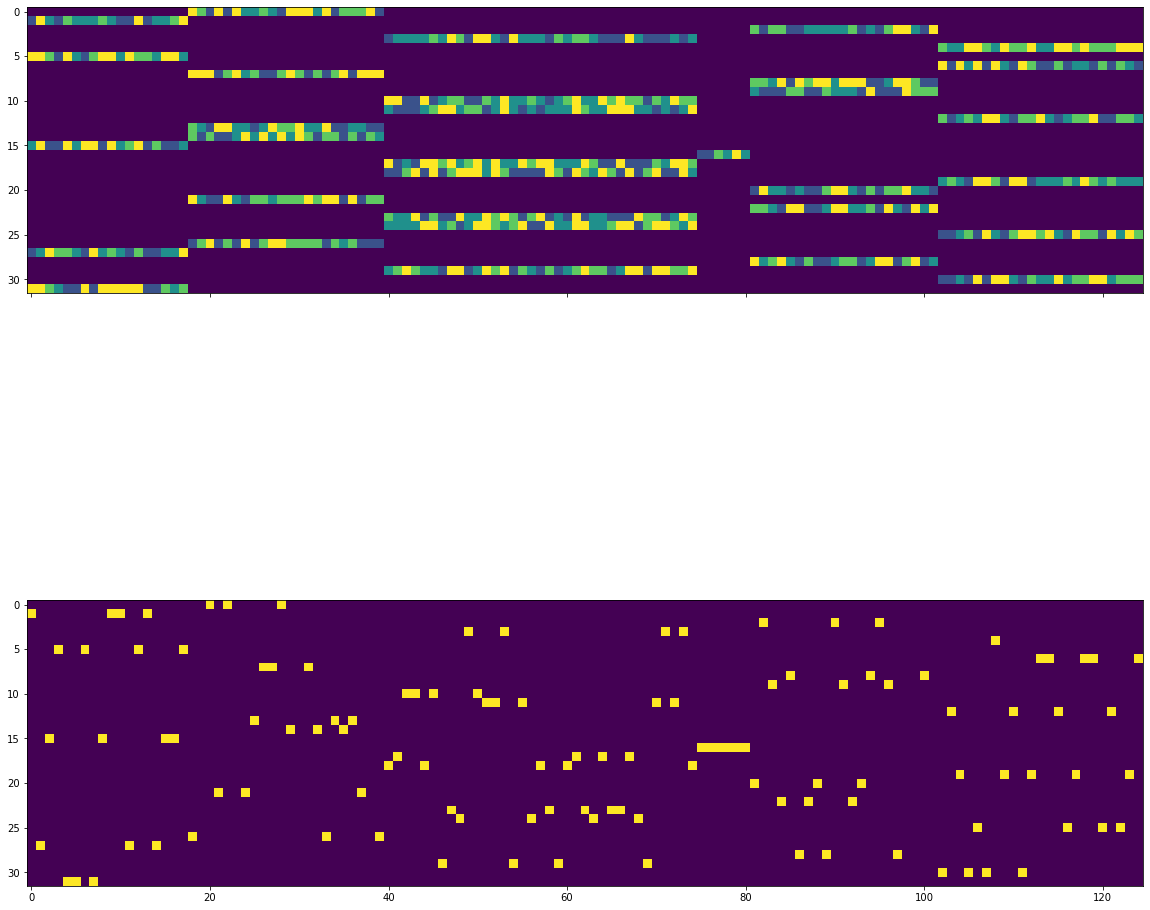

In [17]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,20))
ax1.imshow(cib[:,:32].T,interpolation='nearest')
ax2.imshow(assignments[:,:32].T,interpolation='nearest')
plt.savefig("Random block costs weekly schedule",dpi=500)

In [18]:
os = [[] for _ in range(n_blocks)]
gs = [[] for _ in range(n_blocks)]

for b in range(n_blocks):
    for n in range(n_scenarios):
        os[b].append(avg_model.o[b+1,n+1].value)
        gs[b].append(avg_model.g[b+1,n+1].value)

os = np.array(os)
gs = np.array(gs)

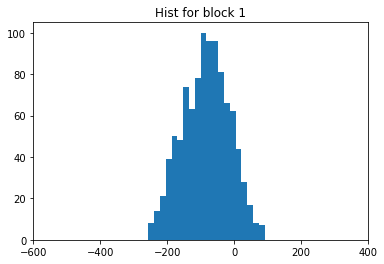

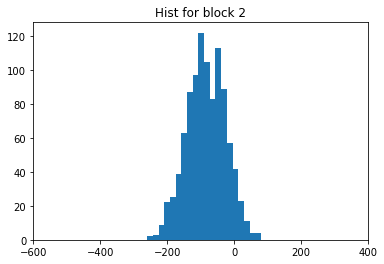

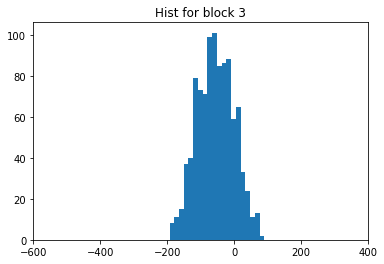

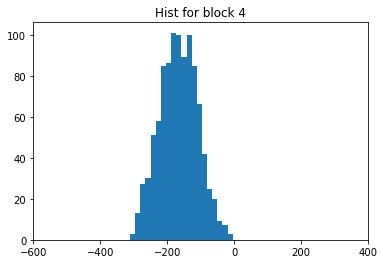

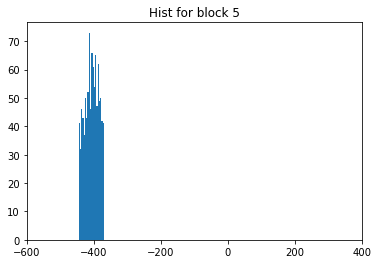

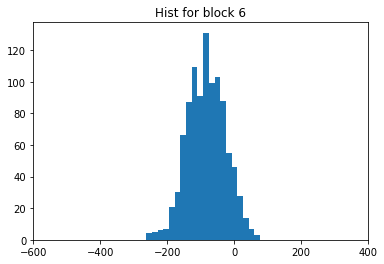

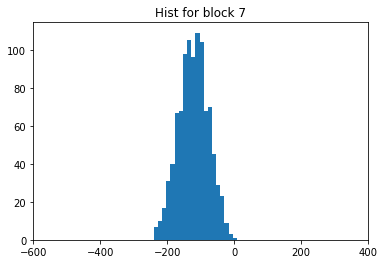

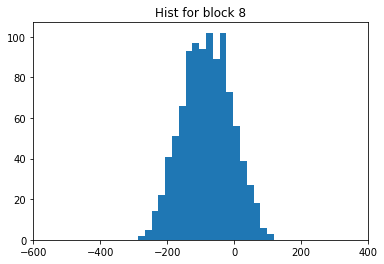

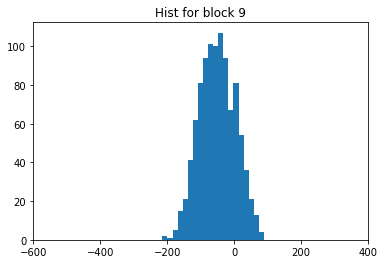

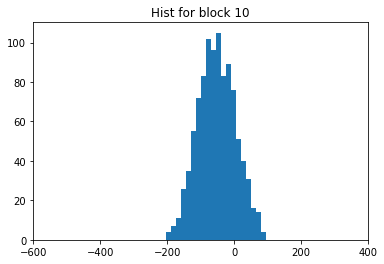

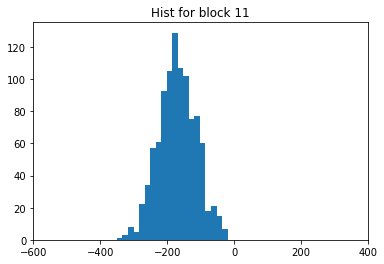

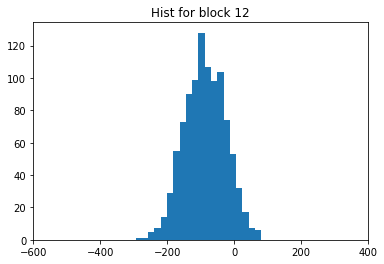

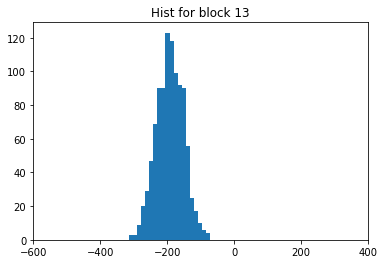

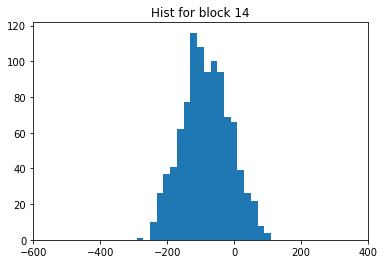

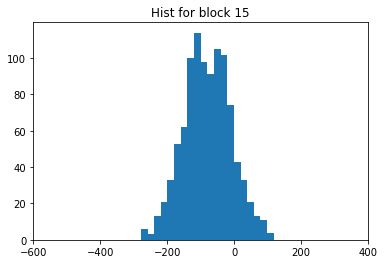

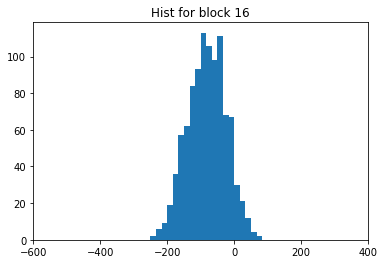

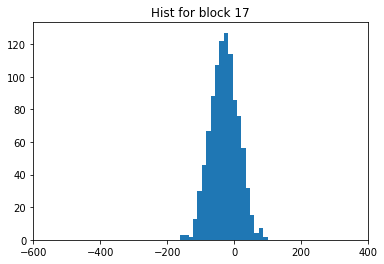

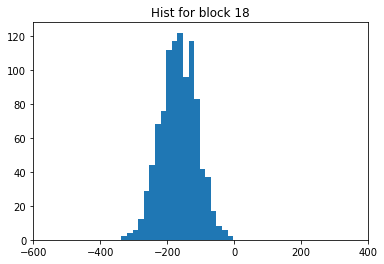

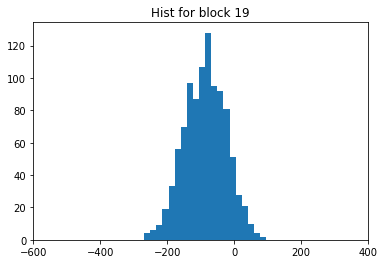

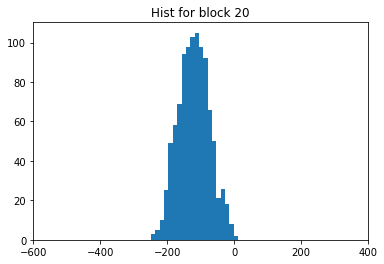

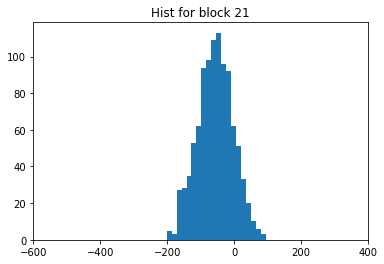

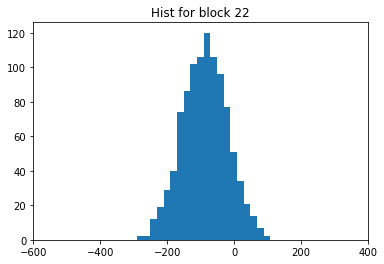

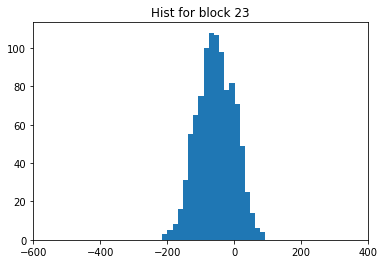

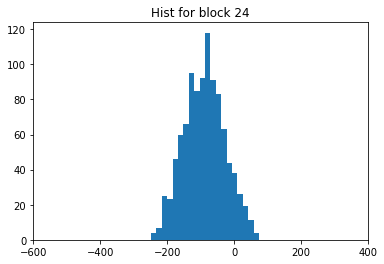

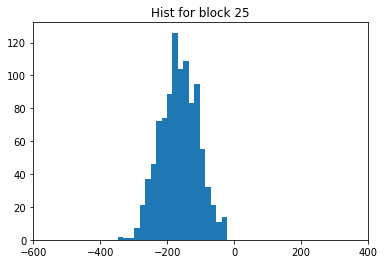

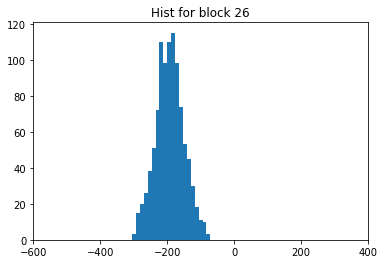

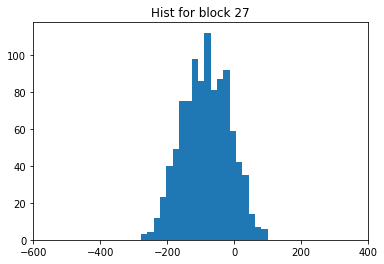

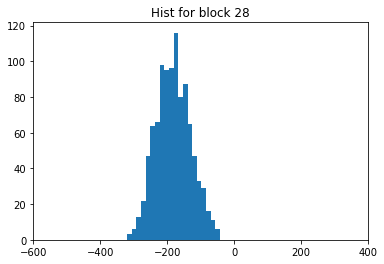

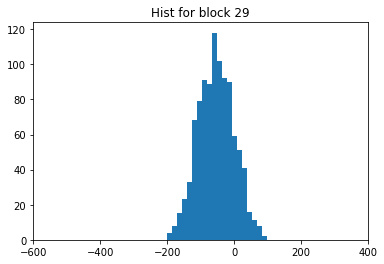

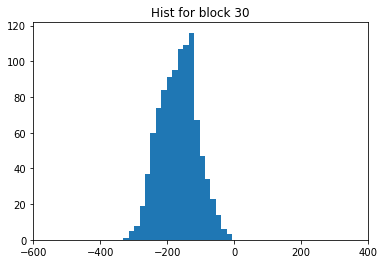

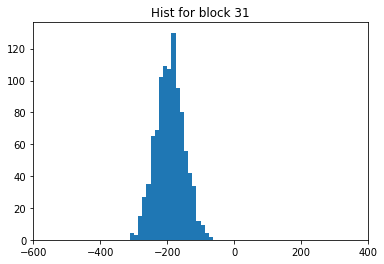

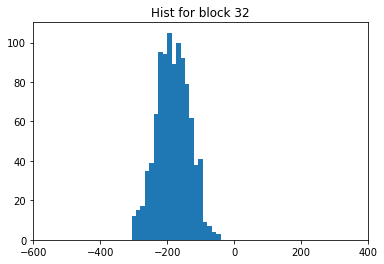

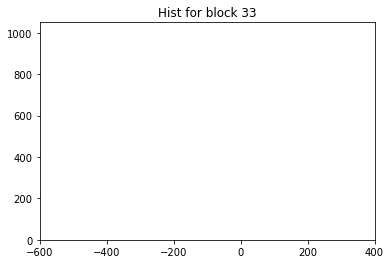

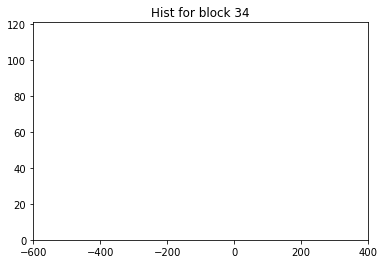

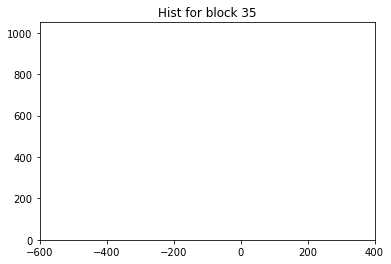

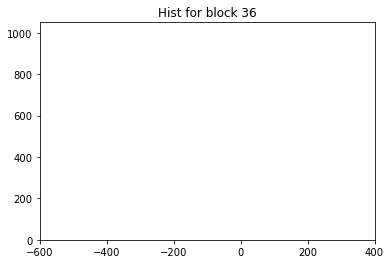

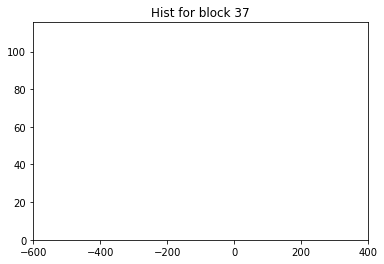

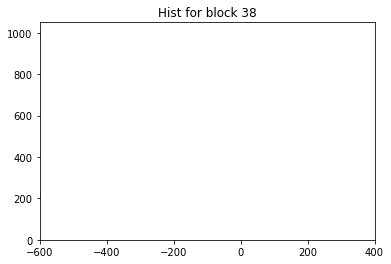

In [19]:
overtime = os-gs

for b in range(n_blocks):
    plt.figure()
    plt.title("Hist for block "+str(b+1))
    plt.hist(overtime[b],bins=20)
    plt.xlim(-600,400)
    plt.show()

In [20]:
cib

array([[   0.,  100.,    0., ...,    0.,    0.,    0.],
       [   0.,  400.,    0., ...,    0.,    0.,    0.],
       [   0.,  200.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0., 1000.],
       [   0.,    0.,    0., ...,    0.,    0., 1000.],
       [   0.,    0.,    0., ...,    0.,    0., 1000.]])

In [21]:
cib[:,33]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])

In [22]:
cib[9,:]

array([   0.,  200.,    0.,    0.,    0.,  400.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,  400.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        300.,    0.,    0.,    0.,  400., 1000.,    0.,    0.,    0.,
          0.,    0.])

In [23]:
cib[:2,:32]

array([[  0., 100.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0., 400.],
       [  0., 400.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0., 400.]])

In [24]:
cib.shape

(125, 38)

In [25]:
overtime[33]

array([-5444.26174997, -5457.624836  , -5375.10643412, -5445.88049718,
       -5384.05238215, -5407.56931809, -5351.14826091, -5395.06312681,
       -5440.56919059, -5352.79635395, -5584.27639325, -5273.2489354 ,
       -5434.44065962, -5508.45366405, -5484.4637106 , -5390.04338591,
       -5548.45986774, -5567.14116453, -5493.03313662, -5512.58804301,
       -5362.11767178, -5390.92958756, -5390.09434342, -5492.29600701,
       -5486.03794465, -5533.76123667, -5527.70839478, -5472.9782446 ,
       -5558.04998776, -5421.75141222, -5601.36357913, -5356.39495578,
       -5483.60751117, -5548.73335863, -5465.98507687, -5493.87718411,
       -5587.10654975, -5405.81930618, -5482.83125467, -5459.34717067,
       -5558.11193158, -5453.81254086, -5417.54655365, -5543.70095232,
       -5493.44575856, -5317.14309056, -5429.84405267, -5546.31989482,
       -5389.55816988, -5532.84795045, -5499.27972517, -5522.17072144,
       -5375.0146681 , -5492.66786474, -5431.34232236, -5561.19699461,
      

In [26]:
cib[14,:]

array([   0.,  200.,    0.,    0.,    0.,  200.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,  300.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        100.,    0.,    0.,    0.,  100., 1000.,    0.,    0.,    0.,
          0.,    0.])

In [27]:
overtime[33]

array([-5444.26174997, -5457.624836  , -5375.10643412, -5445.88049718,
       -5384.05238215, -5407.56931809, -5351.14826091, -5395.06312681,
       -5440.56919059, -5352.79635395, -5584.27639325, -5273.2489354 ,
       -5434.44065962, -5508.45366405, -5484.4637106 , -5390.04338591,
       -5548.45986774, -5567.14116453, -5493.03313662, -5512.58804301,
       -5362.11767178, -5390.92958756, -5390.09434342, -5492.29600701,
       -5486.03794465, -5533.76123667, -5527.70839478, -5472.9782446 ,
       -5558.04998776, -5421.75141222, -5601.36357913, -5356.39495578,
       -5483.60751117, -5548.73335863, -5465.98507687, -5493.87718411,
       -5587.10654975, -5405.81930618, -5482.83125467, -5459.34717067,
       -5558.11193158, -5453.81254086, -5417.54655365, -5543.70095232,
       -5493.44575856, -5317.14309056, -5429.84405267, -5546.31989482,
       -5389.55816988, -5532.84795045, -5499.27972517, -5522.17072144,
       -5375.0146681 , -5492.66786474, -5431.34232236, -5561.19699461,
      

In [28]:
os

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.00001429e-09],
       [ 0.00000000e+00,  0.00000000e+00,  6.39816711e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.38643924e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [29]:
gs

array([[1.45557274e+02, 1.84252803e+01, 5.57542554e+01, ...,
        9.89281156e+01, 1.02669643e+02, 6.97151917e+00],
       [4.99888272e+01, 8.59903592e+01, 0.00000000e+00, ...,
        1.50017269e+01, 6.85442119e+01, 3.45930165e+01],
       [0.00000000e+00, 1.41562823e+02, 6.80897892e+01, ...,
        3.61472711e+00, 5.09979043e+01, 9.49276178e+01],
       ...,
       [6.00000000e+03, 6.00000000e+03, 6.00000000e+03, ...,
        6.00000000e+03, 6.00000000e+03, 6.00000000e+03],
       [5.45927419e+03, 5.60356848e+03, 5.65758179e+03, ...,
        5.60230507e+03, 5.55006061e+03, 5.62209362e+03],
       [6.00000000e+03, 6.00000000e+03, 6.00000000e+03, ...,
        6.00000000e+03, 6.00000000e+03, 6.00000000e+03]])

In [30]:
cib[103,:]

array([   0.,    0.,    0.,    0.,  200.,    0.,  100.,    0.,    0.,
          0.,    0.,    0.,  100.,    0.,    0.,    0.,    0.,    0.,
          0.,  300.,    0.,    0.,    0.,    0.,    0.,  100.,    0.,
          0.,    0.,    0.,  100.,    0.,    0.,    0.,    0.,    0.,
          0., 1000.])

In [31]:
cib.shape

(125, 38)

In [32]:
pd.DataFrame(os).to_csv("osdata_125Surgeries_nobounds_corrected.csv")
pd.DataFrame(gs).to_csv("gsdata_125Surgeries_nobounds_corrected.csv")

In [33]:
os_bnd_125 = np.array(pd.read_csv("osdata_125Surgeries.csv"))[:32,1:]
gs_bnd_125 = np.array(pd.read_csv("gsdata_125Surgeries.csv"))[:32,1:]

os_bnd_100 = np.array(pd.read_csv("osdata_100Surgeries.csv"))[:32,1:]
gs_bnd_100 = np.array(pd.read_csv("gsdata_100Surgeries.csv"))[:32,1:]

print(os_bnd_125.shape,os_bnd_100.shape)
print(gs_bnd_125.shape,gs_bnd_100.shape)



(32, 1000) (32, 1000)
(32, 1000) (32, 1000)


In [34]:
for s in specs:
    print(s)
    for b in blocks[s]:
        if b <= 32:
            print("  Block:",b,"  Overtime:",np.mean(os_bnd_100[b-1,:]),np.mean(os_bnd_125[b-1,:]))
            print("  Block:",b,"  Idletime:",np.mean(gs_bnd_100[b-1,:]),np.mean(gs_bnd_125[b-1,:]))
    print("")

CARD
  Block: 2   Overtime: 0.0 1.3973610246238741
  Block: 2   Idletime: 183.41698076977787 84.07182500222488
  Block: 6   Overtime: 0.0 0.0
  Block: 6   Idletime: 280.8605081177769 182.85948668657662
  Block: 16   Overtime: 0.0 1.5581043343689434
  Block: 16   Idletime: 181.99497885904722 86.9522907749641
  Block: 28   Overtime: 0.0 0.0
  Block: 28   Idletime: 181.3761570200252 181.48672044415056
  Block: 32   Overtime: 0.0 1.5114926569574259
  Block: 32   Idletime: 182.3406451487189 84.68561686884408

GASTRO
  Block: 1   Overtime: 4.886650404880752 4.156330375408991
  Block: 1   Idletime: 80.92671722255372 88.41258085504984
  Block: 8   Overtime: 3.815281665175108 3.4311541179361202
  Block: 8   Idletime: 86.05587810758391 90.70449501987372
  Block: 14   Overtime: 3.2485617894521672 4.235284715869302
  Block: 14   Idletime: 87.79554161370129 90.03256552601766
  Block: 15   Overtime: 3.969927582698121 4.754174478915259
  Block: 15   Idletime: 87.00460741259317 85.31873212636717
  Blo

In [35]:
print("  Overtime:",np.mean(os_bnd_100[:,:]),np.mean(os_bnd_125[:,:]))
print("  Idletime:",np.mean(gs_bnd_100[:,:]),np.mean(gs_bnd_125[:,:]))

  Overtime: 1.4567671831434592 2.1494335775827795
  Idletime: 166.70633058272705 120.71043827735544


In [37]:
for i in range(n_surgeries):
    val = avg_model.y[i+1,5].value
    if val > 0:
        print(i+1)

109
